In [44]:
import pandas as pd
import json

In [45]:
radar_df = pd.read_csv("data/processed data/radar_data_7.csv")
lidar_df = pd.read_csv("data/processed data/lidar_data_7.csv")


In [48]:
def change_withdelay(delta_t = 0.06):
    with open(f"data/raw data/radar_positions.json", "r") as file:
        radar_positions = {float(k): v for k, v in json.load(file).items()}

    for i, cords in radar_positions.items():
        for j, ax in enumerate(("X, (m)", "Y, (m)")):
            radar_df.loc[radar_df["radar_idx"] == i, ax] -= cords[j]

    vector_length = (radar_df['X, (m)']**2 + radar_df['Y, (m)']**2)**0.5
    radar_df['RadialDelta'] = (delta_t - radar_df['(radar_point_ts - lidar_ts), (s)']) * radar_df['AbsoluteRadialVelocity']
    radar_df['XwithDelta'] = radar_df['X, (m)'] * (vector_length + radar_df['RadialDelta']) / vector_length
    radar_df['YwithDelta'] = radar_df['Y, (m)'] * (vector_length + radar_df['RadialDelta']) / vector_length

    for i, cords in radar_positions.items():
        for j, ax in enumerate(("XwithDelta", "YwithDelta")):
            radar_df.loc[radar_df["radar_idx"] == i, ax] += cords[j]

    for i, cords in radar_positions.items():
        for j, ax in enumerate(("X, (m)", "Y, (m)")):
            radar_df.loc[radar_df["radar_idx"] == i, ax] += cords[j]

    return radar_df

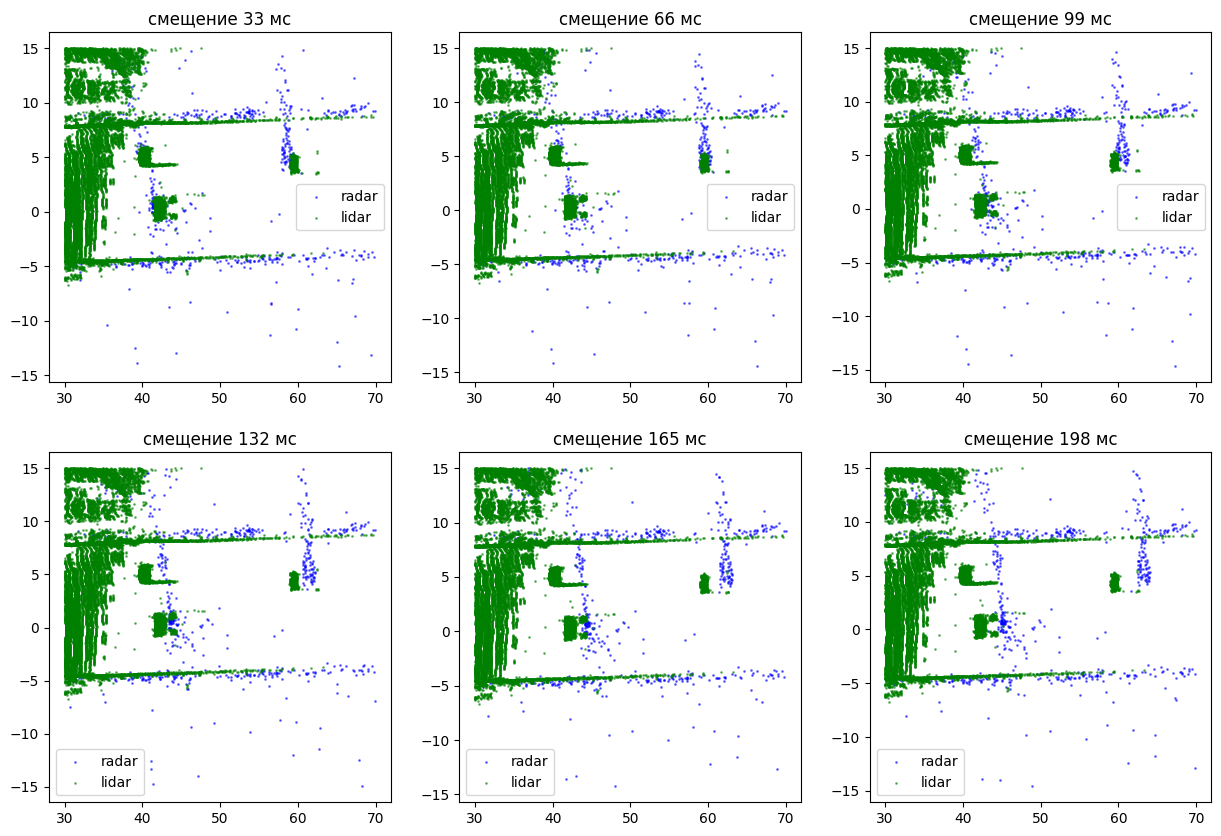

In [57]:
import matplotlib.pyplot as plt

change_withdelay(delta_t=0.2)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (a, b) in enumerate([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]):
    radar_df = pd.read_csv("data/processed data/radar_data_7.csv")
    lidar_df = pd.read_csv("data/processed data/lidar_data_7.csv")
    change_withdelay(delta_t=(0.033 * (i + 1)))
    axes[a, b].scatter(
        radar_df[
            (radar_df["QPDH0"] < 0.75)
            & (abs(radar_df["XwithDelta"] - 50) < 20)
            & (abs(radar_df["YwithDelta"]) < 15)
        ]["XwithDelta"],
        radar_df[
            (radar_df["QPDH0"] < 0.75)
            & (abs(radar_df["XwithDelta"] - 50) < 20)
            & (abs(radar_df["YwithDelta"]) < 15)
        ]["YwithDelta"],
        s=1,
        c="blue",
        alpha=0.5,
        label="radar"
    )
    axes[a, b].scatter(
        lidar_df[(abs(lidar_df["X, (m)"] - 50) < 20) & (abs(lidar_df["Y, (m)"]) < 15)][
            "X, (m)"
        ],
        lidar_df[(abs(lidar_df["X, (m)"] - 50) < 20) & (abs(lidar_df["Y, (m)"]) < 15)][
            "Y, (m)"
        ],
        s=1,
        c="green",
        alpha=0.5,
        label="lidar"
    )

    axes[a, b].set_title(f"смещение {i * 33 + 33} мс")
    axes[a, b].legend()